# Assignment 5: Mapping heterogeneous neural data

This assignment will demonstrate how to integrate hetergeneous datasets that can map features to the human brain. Once mapped, you can perform statistical analyses.

**PLEASE DO NOT CHANGE THE NAME OF THIS FILE.**

**PLEASE DO NOT COPY & PASTE OR DELETE CELLS INCLUDED IN THE ASSIGNMENT.**

_**This notebook was largely developed by Voytek lab PhD alumnus, [Richard Gao](http://www.rdgao.com).**_


## Installing packages on datahub

For this assignment, you'll need a few packages. Specifically, you need to install:

- [nibabel](https://nipy.org/nibabel/): Neuroimaging in Python
- [pysurfer](https://pysurfer.github.io): Visualizing brain imaging data

Due to dependencies, you might also need to install:

- [sobol_seq](https://pypi.org/project/sobol-seq/0.1.1/): Sobol sequence generator


From the datahub ```Files``` browser, you'll see a dropdown menu titles ```New```. From there select ```Terminal```, and that will open a new terminal window.

Once in the Terminal, execute the following command:

```
pip install nibabel
pip install pysurfer
pip install sobol_seq
```

This will install the aboves packages that you'll be using in this assignment.


## How to complete assignments

Whenever you see:

```
# YOUR CODE HERE
raise NotImplementedError()
```

You need to **replace (meaning, delete) these lines of code with code that answers the questions** and meets the specified criteria. Make sure you remove the 'raise' line when you do this (or your notebook will raise an error, regardless of any other code, and thus fail the grading tests).

You should write the answer to the questions in those cells (the ones with `# YOUR CODE HERE`), but you can also add extra cells to explore / investigate things if you need / want to. 

Any cell with `assert` statements in it is a test cell. You should not try to change or delete these cells. Note that there might be more than one assert that tests a particular question. 

If a test does fail, reading the error that is printed out should let you know which test failed, which may be useful for fixing it.

Note that some cells, including the test cells, may be read only, which means they won't let you edit them. If you cannot edit a cell - that is normal, and you shouldn't need to edit that cell.


## Tips & Tricks

The following are a couple tips & tricks that may help you if you get stuck on anything.

#### Printing Variables
You can (and should) print and check variables as you go. This allows you to check what values they hold, and fix things if anything unexpected happens.

#### Restarting the Kernel
- If you run cells out of order, you can end up overwriting things in your namespace. 
- If things seem to go weird, a good first step is to restart the kernel, which you can do from the kernel menu above.
- Even if everything seems to be working, it's a nice check to 'Restart & Run All', to make sure everything runs properly in order.

# Mapping neural data to the human neocortex
---
In this section we'll show you how to take different neural data and map them to the human neocortex. Specifically, we'll be using the Glasser parcellation scheme ([Glasser _et al._, _Nature_ 2016](https://www.nature.com/articles/nature18933)) for segmenting the cortex into distinct regions. This scheme is based (currently) on data from over 1000 young adults collected as part of the [Human Connectome Project (HCP)](https://en.wikipedia.org/wiki/Human_Connectome_Project). It uses as semi-automated machine learning apporach to identify distinct cortical regions, based on a combination of cortical architecture, function, white matter connectivity, and topography. This parcellation scheme identifies 180 distinct cortical regions per hemisphere.

Normally this kind of plotting is a non-trivial process, partly because it relies on some large external libraries that contains the coordinates for the Glasser parcellation maps. However we have extracted that parcellation map data and included it in the `./data` folder.

Below, we begin with the standard library imports, as well as importing our two new packages:
* nibabel
* pysurfer (surfer)

For inline plotting of the parcellation maps, you may need to use the jupyter magic `%gui qt`, which I've also included in the code block below.

We're also including a helper function, `plot_MMP`, for plotting the cortical maps.

In [1]:
%matplotlib inline
%gui qt
# the above might be required for inline visualization of brain images

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# non-standard libraries
import nibabel as ni
from surfer import Brain

In [2]:
# helper function for plotting the parcellation results
def plot_MMP(data, minmax=None, thresh=None, cmap='inferno', alpha=1, add_border=False, bp=0, title=None):
    """
    Plots arbitrary array of data onto MMP parcellation
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ## Following this tutorial
    # https://github.com/nipy/PySurfer/blob/master/examples/plot_parc_values.py
    mmp_labels, ctab, names = ni.freesurfer.read_annot('./data/lh.HCPMMP1.annot')

    if len(names)-len(data)==1:
        # short one label cuz 0 is unassigned in the data, fill with big negative number
        data_app = np.hstack((-1e6,data))
        vtx_data = data_app[mmp_labels]
    else:
        vtx_data = data[mmp_labels]
        vtx_data[mmp_labels < 1] = -1e6

    # plot brain
    brain = Brain('fsaverage', 'lh', 'inflated', subjects_dir='./data/',
                  cortex=None, background='white', size=800, show_toolbar=False, offscreen=True)

    if add_border:
        brain.add_annotation((mmp_labels, np.array([[0,0,0, c[3], c[4]] for c in ctab])))

    if minmax is None:
        minmax = [np.min(data), np.max(data)]

    # add data
    if thresh is None:
        thresh = minmax[0]
    brain.add_data(vtx_data, minmax[0], minmax[1], colormap=cmap, alpha=alpha, colorbar=False, thresh=thresh)
    
    # plot brain views
    brainviews = brain.save_imageset(None, ['lat', 'med'])

    # merge brainviews and plot horizontally
    plt.imshow(np.concatenate(brainviews, axis=1), cmap=cmap)
    sns.despine(bottom=True, left=True)
    plt.xticks([])
    plt.yticks([])
    cbaxes = inset_axes(plt.gca(), width="50%", height="4%", loc=8, borderpad=bp)
    plt.colorbar(cax=cbaxes, orientation='horizontal')
    plt.clim(minmax[0], minmax[1])
    if title is not None:
        plt.title(title)
        
brain_fig_size = (8,8)
def_fig_size = (4,4)

## Q1: Loading in the data for plotting
---
Included in this part of the assignment are two `csv` files in the `./data` directory:
* df_tau.csv
* df_t1t2.csv

The `df_tau.csv` file has two columns, where the first is the name of the brain region in the Glasser parcellation scheme, and the second is the (log10) average neuronal population timescale ($\tau$) estimated from intracranial EEG data collected from 105 patients undergoing surgery for epilepsy.

iEEG data are from [Frauscher _et al._, _Brain_ 2018](https://doi.org/10.1093/brain/awy035) and [Frauscher _et al._, _Annals of Neurology_ 2018](https://doi.org/10.1002/ana.25304); population neuronal timescales are estimated using the mathod introduced by [Gao _et al._, _eLife_ 2020](https://elifesciences.org/articles/61277) and are then averaged by parcel, across all iEEG participants who had data in that region.

The `df_t1t2.csv` file also has two columns, where the first is the same set of brain region names in the Glasser parcellation, and the second is T1w/T2w ratio, which captures gray matter myelination, which indexes the proportion of feedforward vs. feedback connections between cortical regions, where a larger ratio indicates more heavy myelination. "Lower-level" sensory input and motor output regions tend to be more heavily myelinated, whereas "higher-level" association regions tend to be less myelinated. This measure therefore acts as a noninvasive proxy of anatomical hierarchy. This is based on the approach introduced in [Burt _et al._, _Nature Neuroscience_ 2018](https://www.nature.com/articles/s41593-018-0195-0).

Load these two files into two separate pandas dataframes, respectively named:
* df_tau
* df_t1t2

In [3]:
# Load the data into pandas

### BEGIN SOLUTION
# load data
data_path = './data/'
df_tau = pd.read_csv(data_path+'df_tau.csv', index_col=0)
df_t1t2 = pd.read_csv(data_path+'df_t1t2.csv', index_col=0)
### END SOLUTION

## QUESTION 2:
---
Using the `plot_MMP` function supplied above, make two plots: one for tau and one for the T1/T2 ratio. The `plot_MMP` function supplied above takes in a dataframe as an input, and checks to see if the brain region names are included as a feature. Using those names, it then maps the data in the second column to those regions.

For the tau plot, set the colormap (`cmap`) to `'inferno'`; for the T1/T2 map, set it to `'pink'`.

For both plots, set the colorscale (`minmax`) to range from $1$ to $log_{10}(50)$ by passing as an argument to `plot_MMP` a variable called `minmax` that sets that range.

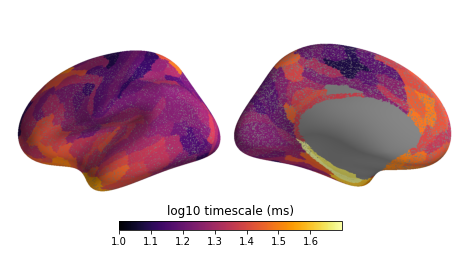

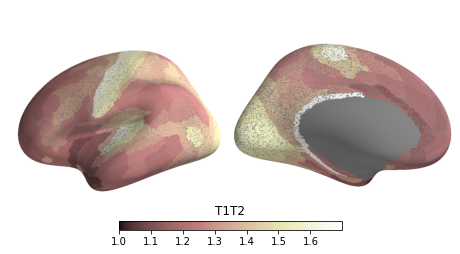

In [4]:
# Plot the Glasser tau and T1/T2 maps

### BEGIN SOLUTION
minmax = [1,np.log10(50)]

plt.figure(figsize=brain_fig_size)
plot_MMP(df_tau['logtau'], minmax=minmax, title='log10 timescale (ms)', cmap='inferno')
plt.show()

plt.figure(figsize=brain_fig_size)
plot_MMP(df_t1t2['T1T2'], minmax=minmax, title='T1T2', cmap='pink')
plt.show()
### END SOLUTION

## Q3
---
Eyeballing the tau map above, which region looks like it has the _longest_ (highest) timescale?

* `A`: Wernicke's area
* `B`: primary motor cortex
* `C`: orbitofrontal cortex
* `D`: medial temporal lobe

Write your answer below as a new variable, `q3_tau_answer`. So if the answer was a hypothetical option `E`, you would write: `q3_tau_answer = 'E'`.

Eyeballing the T1/T2 map above, which region looks like it's the most heavily myelinated?

* `A`: primary motor cortex
* `B`: Broca's area
* `C`: dorsolateral prefrontal cortex
* `D`: inferior temporal gyrus

Write your answer below as a new variable, `q3_t1t2_answer`.

Looking at the figures above, how woudld describe their spatial correlation?
* `A`: positively correlated (regions with higher tau have _higher_ T1/T2 ratio)
* `B`: negatively correlated (regions with higher tau have _lower_ T1/T2 ratio)
* `C`: uncorrelated

Write your answer below as a new variable, `q3_correlation_answer`.

## Q4
---
* Plot a scatterplot of T1/T2 (x-axis) and tau (y-axis).
* Compute the non-linear spearman correlation (from scipy) and save the spearman correlation coefficient as `rho` and the p-value as `pv`.

spearman correlation coefficient: -0.4656, p-value: 0.0000


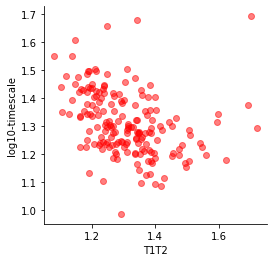

In [5]:
# Scatterplot and spearman test for correlation

### BEGIN SOLUTION
from scipy.stats import spearmanr

plt.figure(figsize=def_fig_size)
plt.scatter(df_t1t2['T1T2'], df_tau['logtau'], color='r', alpha=0.5)
plt.xlabel('T1T2')
plt.ylabel('log10-timescale')
sns.despine()

rho, pv = spearmanr(df_t1t2['T1T2'], df_tau['logtau'])
print('spearman correlation coefficient: %.4f, p-value: %.4f'%(rho, pv))
### END SOLUTION


## Q5
---

Based on the correlation coefficient and p-value above, what can you say about population neuronal timescale and myelination?

* `A`: More heavily myelinated regions have shorter (faster) timescales
* `B`: More heavily myelinated regions have larger (slower) timescales
* `C`: Timescales are shortest (fastest) for both weakly and heavily myelinated regions
* `D`: They are unrelated

Write your answer below as a new variable, `q5_significance_answer`. So if the answer was a hypothetical option `E`, you would write: `q5_significance_answer = 'E'`.


### Q6:
---
One concern for statistically comparing maps is that spatial data&mdash;including in the brain!&mdash;are autocorrelated. This means that nearby things tend to be more similar than far away things: the temperature outside your building is likely to be closer to the temperature down the street than it is to the temperature in 4300 km away. Similarly, things tend to "cluster" together in space, rather than to be evenly distributed around the globe (or across the neocortex).

<img src=" https://imgs.xkcd.com/comics/heatmap.png">

Because of this, using a p-value from a correlation with a significance level set at p < 0.05 will result in spurious "significant" correlations far more frequently than 1-in-20 times, assuming the null hypothesis.

To address this, we will teach you how to use surrogate signifcance tests. We'll begin by using normally distributed variables as your surrogate "fake" data.

What we will do is construct "fake" versions of the T1/T2 ratio data that are actually just randomly chosen numbers. We will then and check how likely it is that our randomly constructed datasets achieve a correlation to tau _as strong as_ what we see with our **real T1/T2** data.

To do this, you will start by creating a numpy array of normally distributed numbers with dimensions $M x N$, where $M$ is the number of brain regions in the datasets above, and $N$ is the number of surrogates you want to construct. In this case, we set $N$ to be 1000. You can interpret this as 1000 fake datasets of T1/T2, where each column is one such fake, or, surrogate.

Create a variable called `surrogates` that is an $M x N$ numpy array of random data, where $\mu = 0$ and $\sigma = 1$. Use `np.random.normal` _not_ `np.random.randn`.

In [6]:
# Create 1000 normally-distributed datasets of size M*N

### BEGIN SOLUTION
M, N = df_tau.shape[0], 1000

# use np.random.normal, with a standard Gaussian (mean 0, std 1)
surrogates = np.random.normal(loc=0, scale=1, size=(M,N))
### END SOLUTION


### Q7:
---
* Plot one of your fake datasets, specifically column 138, against the real tau, just like you did above.
* Again, compute the non-linear spearman correlation (from scipy) and save the spearman correlation coefficient as `rho_surrogate` and the p-value as `pv_surrogate`.

Based on the surrogate correlation coefficient and surrogate p-value above, what can you say about population neuronal timescale and normally-distruibuted random data?

* `A`: They are strongly positively correlated
* `B`: They are strongly negatively correlated
* `C`: They are uncorrelated

Write your answer below as a new variable, `q7_surrogate_significance_answer`. So if the answer was a hypothetical option `D`, you would write: `q7_surrogate_significance_answer = 'D'`.


spearman correlation coefficient: -0.0096, p-value: 0.8987


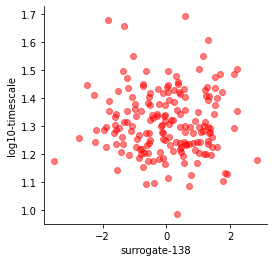

In [7]:
# Scatterplot and spearman test for correlation with surrogate data

### BEGIN SOLUTION
from scipy.stats import spearmanr

plt.figure(figsize=def_fig_size)
plt.scatter(surrogates[:,138], df_tau['logtau'], color='r', alpha=0.5)
plt.xlabel('surrogate-138'); plt.ylabel('log10-timescale'); 
sns.despine()

rho_surrogate, pv_surrogate = spearmanr(surrogates[:,138], df_tau['logtau'])
print('spearman correlation coefficient: %.4f, p-value: %.4f'%(rho_surrogate, pv_surrogate))

q7_surrogate_significance_answer = 'C'
### END SOLUTION


### Q8:
---
Surrogate testing is doing the above this, but for all $N$ surrogate datasets. This lets you see how often you (randomly) achieve a result as strong as your empirical relationship, but against random data.

For a proper surrogate analysis, you need to repeat the above process, but for all 1000 of your surrogate distributions. You don't need to plot the scatterplots again, just make a for loop to repeat the spearman test for all of the surrogates. Save the rho values in a numpy array called `rho_surrogate_vector`.

In [8]:
# Full surrogate analysis

### BEGIN SOLUTION
rho_surrogate_vector = []
for i in range(N):
    rho_surrogate_vector.append(spearmanr(surrogates[:,i], df_tau['logtau'])[0])

rho_surrogate_vector = np.array(rho_surrogate_vector)
### END SOLUTION


### Q9:
---
Finally:
* Plot the distribution of surrogate rho values (use 25 bins).
* Draw a vertical line representing your empirical rho value.
* What percentage of the surrogates crho values achieved as large of a rho value as our real (empirical) rho value? The answer to this is the surrogate p-value. Save this as a variable called `pv_all_surrogates`.

0.0000 percent of the surrogates were more extreme than my data.


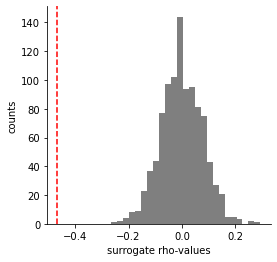

In [9]:
# Plot full surrogate distribution and p-value

### BEGIN SOLUTION

plt.figure(figsize=def_fig_size)

# make histogram
plt.hist(rho_surrogate_vector, 25, color='k', alpha=0.5)

# draw vertical line
plt.axvline(rho, color='r', ls='--')

# label axis
plt.xlabel('surrogate rho-values')
plt.ylabel('counts')
sns.despine()

pv_all_surrogates = sum(abs(rho_surrogate_vector)>abs(rho))/N
print('%.4f percent of the surrogates were more extreme than my data.'%pv_all_surrogates)
### END SOLUTION


That's it! You have just performed a surrogate signifcance test! You can see that our initial result is quite strong, as the spearman p-value reports, if you assume that the data are random and normally-dsitributed.

However, normally distributed surrogates are not great surrogates in this scenario due to the spatial autocorrelation reality that we mentioned above.

The idea behind surrogate testing is to construct surrogate data that captures _all aspects of your original data, except for the putative relationship between the two variables_.

So in the above, we assumed that T1/T2 is a vector of normally-distributed numbers, and we saw that those surrogates are not very correlated with timescale. But this is actually not a great assumption, because normally-distributed numbers do not capture an important property of such brain maps: their spatial autocorrelation. Features across the cortex are continuous and form a gradient, and they vary along the cortex, as you saw in the first figures you generated, but they do so smoothly.

So to improve upon our previous approach, and to make our surrogate test more "fair" and realistic, we can construct better fake data. In this case, I've provided for you 1000 surrogates that mimicks the spatial profile of T1/T2, but it shuffles where the values are.

Below, we plot 3 brain maps: the first using one of your normally distributed surrogates, the second using the spatial autocorrelation (SA)-preserving maps, the last one using the actual T1/T2 data.

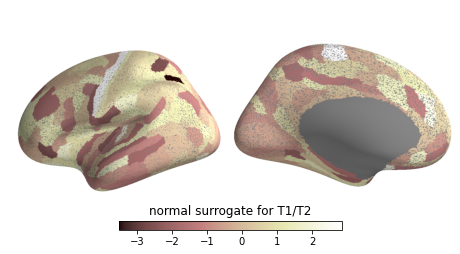

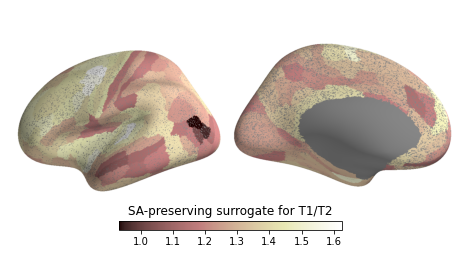

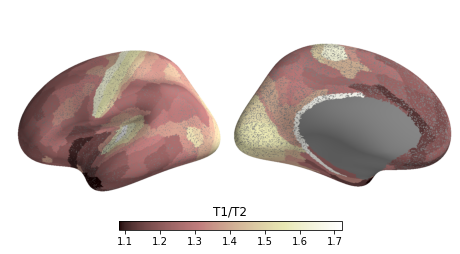

In [10]:
# load surrogates into dataframe
df_SAnulls = pd.read_csv(data_path+'df_t1t2_shuffles.csv', index_col=0)

# HINT: you can provide a column of the surrogate array as the input argument as well
plt.figure(figsize=brain_fig_size)
plot_MMP(surrogates[:,138], bp=0, title='normal surrogate for T1/T2', cmap='pink')

plt.figure(figsize=brain_fig_size)
# HINT: to index the columns of the surrogate dataframe, you have to use numbers in string literals
plot_MMP(df_SAnulls['138'], bp=0, title='SA-preserving surrogate for T1/T2', cmap='pink')

plt.figure(figsize=brain_fig_size)
plot_MMP(df_t1t2['T1T2'], bp=0, title='T1/T2', cmap='pink')

### Q10:
---
Hopefully you'll see how the real T1/T2 map (bottom) is spatially autocorrelated, with nearby features looking more similar while the normal surrogate map is "patchy", or more random. In contrast, the SA-preserving maps are less patchy, and more continuously graded; their randomness is more similar to the the actual T1/T2 maps.

For this question, I want you to:
* Repeat the for-loop surrogate procedure above, but this time comparing tau to the SA-preserving surrogate maps.
* Save the rho values in a numpy array called `rhoSA_surrogate_vector`.
* Plot the distribution of surrogate rho values of the SA-preserving maps (use 25 bins).
* Draw a vertical line representing your empirical rho value.
* What percentage of the surrogates rho values from the SA-preserving maps achieved as large of a rho value as our real (empirical) rho value? The answer to this is the surrogate p-value. Save this as a variable called `pv_allSA_surrogates`.


0.0000 percent of the surrogates were more extreme than my data.


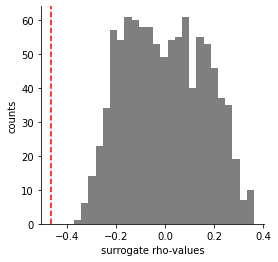

In [11]:
# Plot full surrogate distribution and p-value

### BEGIN SOLUTION
rhoSA_surrogate_vector = []
for i in range(N):
    rhoSA_surrogate_vector.append(spearmanr(df_SAnulls['%i'%i], df_tau['logtau'])[0])

rhoSA_surrogate_vector = np.array(rhoSA_surrogate_vector)

plt.figure(figsize=def_fig_size)

# make histogram
plt.hist(rhoSA_surrogate_vector, 25, color='k', alpha=0.5);
# draw vertical line
plt.axvline(rho, color='r', ls='--')
# label axis
plt.xlabel('surrogate rho-values')
plt.ylabel('counts')
sns.despine()
pv_allSA_surrogates = sum(abs(rhoSA_surrogate_vector)>abs(rho))/N
print('%.4f percent of the surrogates were more extreme than my data.'%pv_allSA_surrogates)
### END SOLUTION


### Q11:
---
Now we can do some data-driven discovery!

Below is the code for loading in the cortical expression maps for 1000 randomly chosen genes (out of ~18k).

Do the following:
* Plot (on the brain) the expression map for the gene GABRA5.
* Which cortical area has the highest expression of GABRA5? Save this name of the region as a string named `GABRA5_region`.
* Plot a scatter plot of GABRA5 and timescale.
* Compute the non-linear spearman correlation between GABRA5 and timescale and save the spearman correlation coefficient as `GABRA5_rho` and the p-value as `GABRA5_pv`.

In [12]:
# load gene data
df_genes = pd.read_csv(data_path+'df_rand_1kgenes.csv', index_col=0)



Expression is highest in EC.
spearman correlation coefficient: 0.6089, p-value: 0.0000


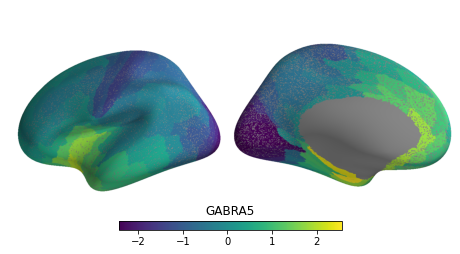

In [13]:
# tau-to-GABRA5 spearman correlation

### BEGIN SOLUTION
plt.figure(figsize=brain_fig_size)
plot_MMP(df_genes['GABRA5'], bp=0, title='GABRA5', cmap='viridis')

GABRA5_region = df_genes['GABRA5'].idxmax()

print('\nExpression is highest in %s.'%GABRA5_region)

GABRA5_rho, GABRA5_pv = spearmanr(df_genes['GABRA5'], df_tau['logtau'])
print('spearman correlation coefficient: %.4f, p-value: %.4f'%(GABRA5_rho, GABRA5_pv))
### END SOLUTION


### Bonus, ungraded Q12:
---
More data-driven discovery!

Now:
* Compute the spearman correlation coefficient for all 1000 genes. Save this as a numpy array called `rho_timescale_genes`.
* Plot that distribution.
* Which genes are most associated with timescale? Save the 3 most positively and the 3 most negatively correlated genes as a list called `timescale_genes`.